# Dimensionality Reduction

## Normalization 

In [ ]:
#@title Load quality controlled data 

adata_QC = sc.read_h5ad(filename= "/content/drive/MyDrive/scRNA_using_Python/Objects/sc_qc_filtered_covid.h5ad")

adata_QC



AnnData object with n_obs × n_vars = 3536 × 7650
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_counts', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'prediction', 'leiden', 'doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'ambient_profile_Gene Expression', 'ambient_profile_all', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'prediction_colors', 'sample_colors', 'type_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambient_counts', 'counts'
    obsp: 'connectivities', 'distances'

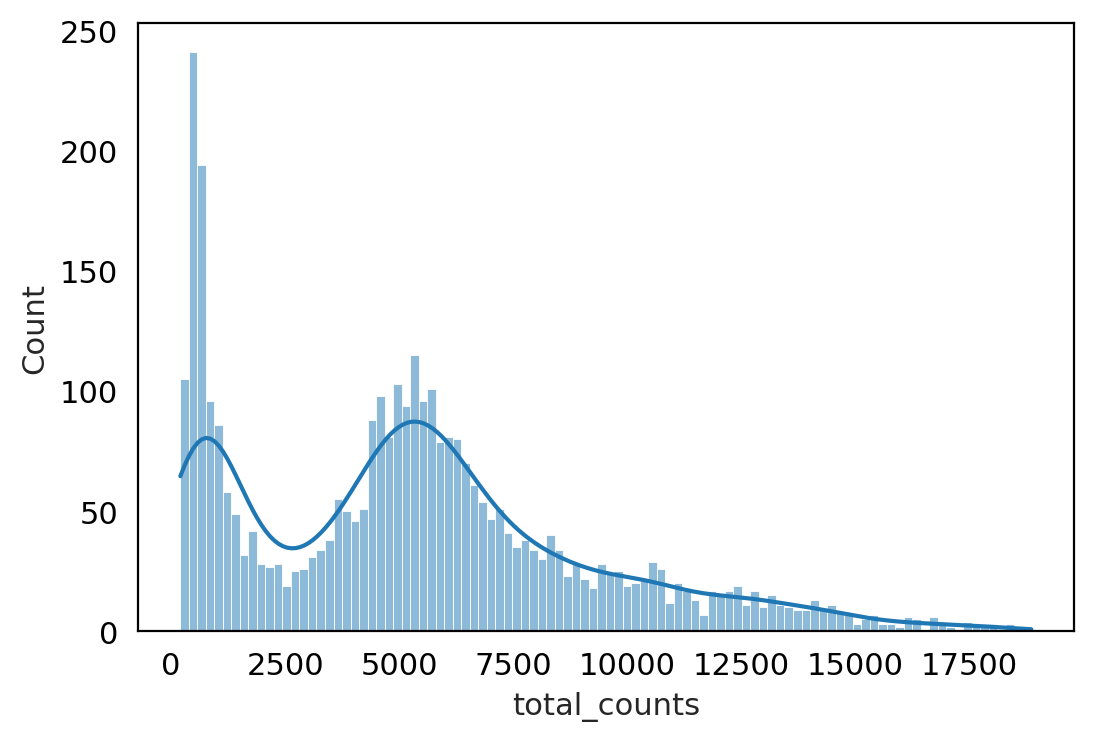

In [ ]:
#@title check count distribution :

p1 = sns.histplot(adata_QC.obs["total_counts"], bins=100, kde= True)



> Note :  

At this stage we have cleaned data according to filtered cells , corrected ambient RNA and doublet removed .

But data we had count Matrix (cells  X  Genes) , still variance due to sampling effect (cell capturing, library preparation, sequencing ) . 

The difference we get between cells gene expression may be because of these sampling effects not by real difference . so we need to Normalize to correct for variance. 

Normalize by 2 methods : 



1.   Log shifted Normalization 


*   doesn't prevent heterogenity
*   corrects for library depth


2.   Pearson residual Normalization (prevents heterogenity)


*   prevent heterogenity
*   corrects for library depth









In [ ]:
#@title Method-1 : Log shifted method :


scales_counts = sc.pp.normalize_total(adata_QC, target_sum=None, inplace=False)
# log1p transform
adata_QC.layers["log1p_norm"] = sc.pp.log1p(scales_counts["X"], copy=True)

adata_QC

AnnData object with n_obs × n_vars = 3536 × 7650
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_counts', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'prediction', 'leiden', 'doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'ambient_profile_Gene Expression', 'ambient_profile_all', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'prediction_colors', 'sample_colors', 'type_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambient_counts', 'counts', 'log1p_norm'
    obsp: 'connectivities', 'distances'

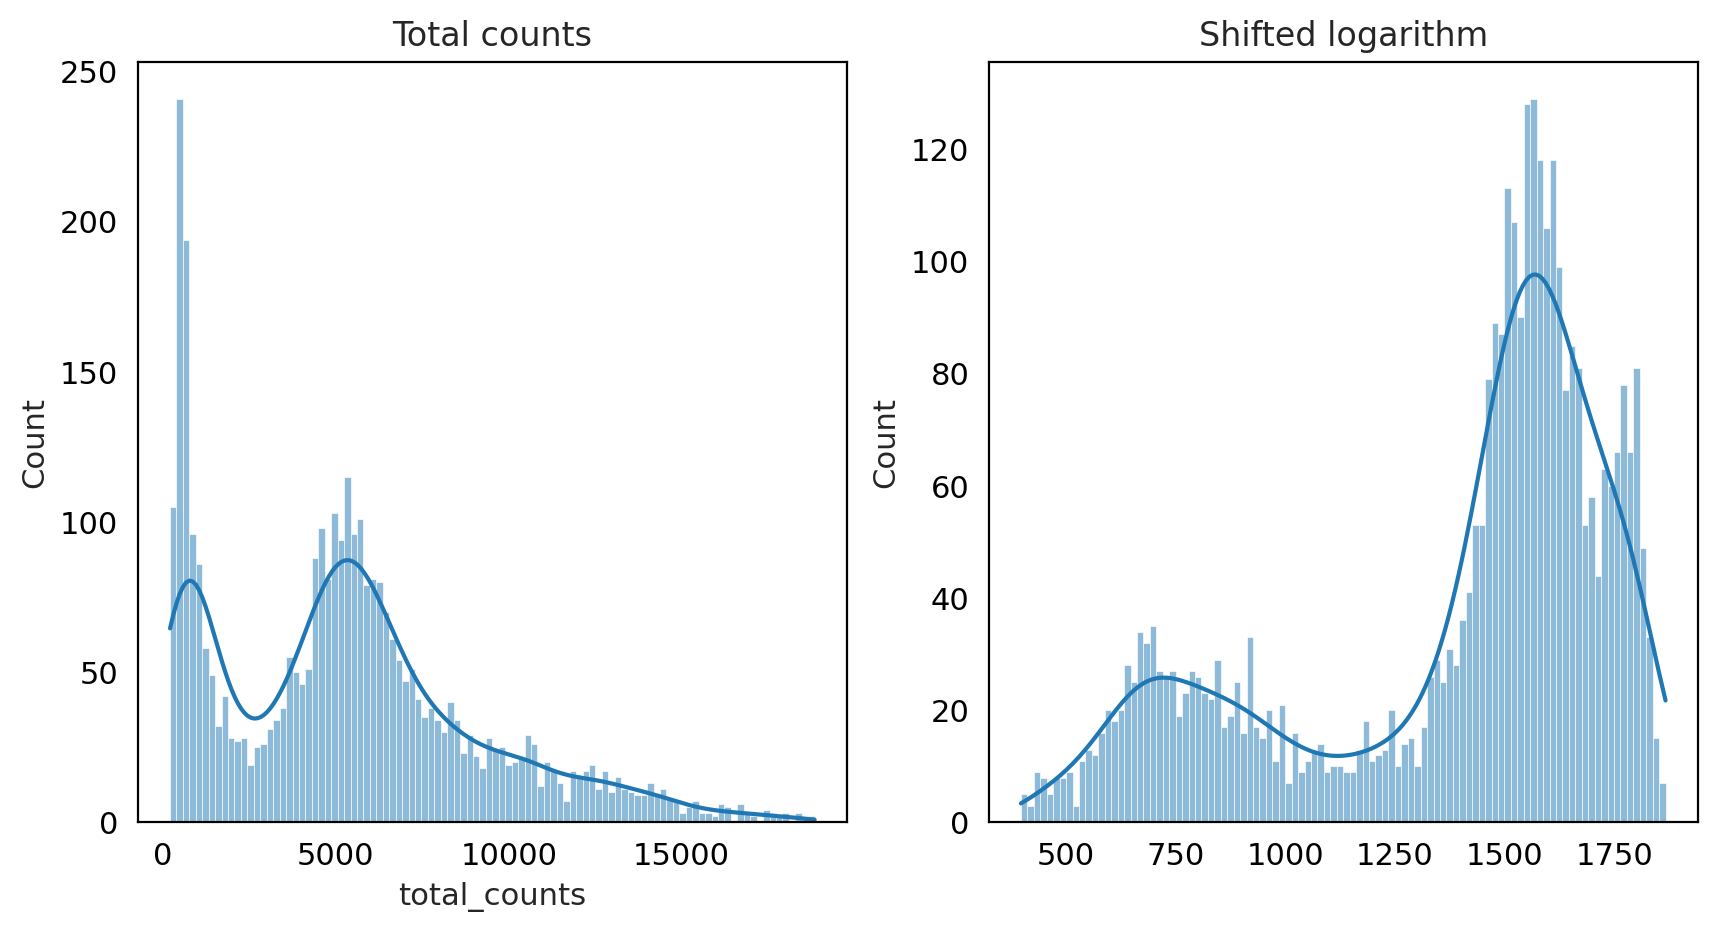

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata_QC.obs["total_counts"], bins=100, kde=True, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(adata_QC.layers["log1p_norm"].sum(1), bins=100, kde=True, ax=axes[1])
axes[1].set_title("Shifted logarithm")
plt.show()

In [ ]:
#@title Method-2 : Analytic Pearson residual method ( APR )




**Pearson Residual** :

In pearson residual method the preprocessed counts are compared to the expected counts of a “null model” ( This Null model includes technical variance cells but  no biological variability between cells.)

Pearson residuals : 

* genes that are not differentially expressed = will have variance close to 1. 

* gene is differentially expressed, it will deviate from the null model, residual variance >1 for that gene




**> Pearson Residual method helps in :**



* Remove the technical variation that comes from library depth 


* stabilize the mean-variance relationship across genes, i.e. ensure that biological signal from both low and high expression genes can contribute similarly to downstream processing


* genes that are homogenously expressed (like housekeeping genes) have small variance, while genes that are differentially expressed (like marker genes) have high variance



In [ ]:

analytic_pearson = sc.experimental.pp.normalize_pearson_residuals(adata_QC, inplace=False)
adata_QC.layers["APR_counts"] = csr_matrix(analytic_pearson["X"])

adata_QC


AnnData object with n_obs × n_vars = 3536 × 7650
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_counts', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'prediction', 'leiden', 'doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'ambient_profile_Gene Expression', 'ambient_profile_all', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'prediction_colors', 'sample_colors', 'type_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambient_counts', 'counts', 'log1p_norm', 'APR_counts'
    obsp: 'connectivities', 'distances'

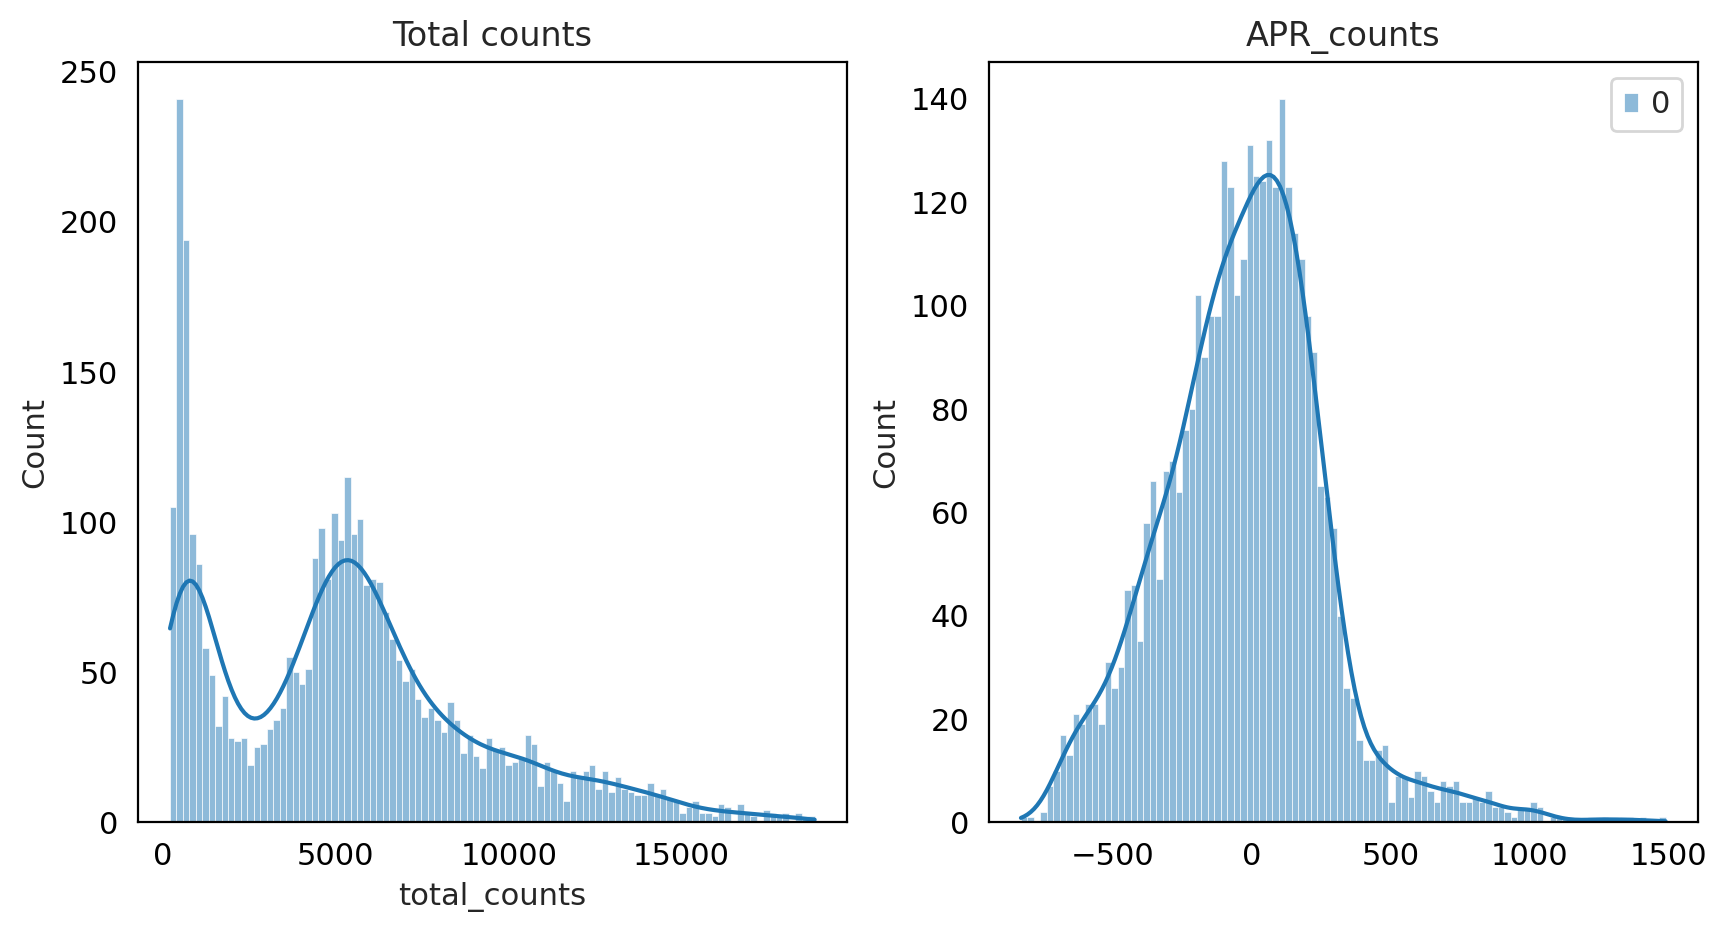

In [ ]:


fig, axes = plt.subplots(1, 2, figsize=(10, 5))
p1 = sns.histplot(adata_QC.obs["total_counts"], bins=100, kde=True, ax=axes[0])
axes[0].set_title("Total counts")
p2 = sns.histplot(
    adata_QC.layers["APR_counts"].sum(1), bins=100, kde=True, ax=axes[1]
)
axes[1].set_title("APR_counts")
plt.show()


As you can see for this data Pearson Residual method performed well . 

In [ ]:
adata_QC

AnnData object with n_obs × n_vars = 3536 × 7650
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_counts', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'prediction', 'leiden', 'doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'ambient_profile_Gene Expression', 'ambient_profile_all', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'prediction_colors', 'sample_colors', 'type_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambient_counts', 'counts', 'log1p_norm', 'APR_counts'
    obsp: 'connectivities', 'distances'

## Feature Selection

In [ ]:
#@title select features

%%R
library(scry)

In [ ]:
# Don/t run this in %%R because it is python code 

ro.globalenv["adata_QC"] = adata_QC

In [ ]:
%%R
sce = devianceFeatureSelection(adata_QC, assay="X")
sce

class: SingleCellExperiment 
dim: 7650 3536 
metadata(13): _scvi_manager_uuid _scvi_uuid ... type_colors umap
assays(5): X ambient_counts counts log1p_norm APR_counts
rownames(7650): AL669831.5 FAM41C ... AL592183.1 AC004556.1
rowData names(14): gene_ids feature_types ... std binomial_deviance
colnames(3536): AGGGTCCCATGACCCG-1-0 ATTCCTAGTGACTGTT-1-0 ...
  GAGGCCTTCTCCTGCA-14-5 CCCTAACAGTTTCTTC-14-5
colData names(23): type sample ... leiden doublet
reducedDimNames(2): PCA UMAP
mainExpName: NULL
altExpNames(0):


In [ ]:
binomial_deviance = ro.r("rowData(sce)$binomial_deviance").T

In [ ]:
idx = binomial_deviance.argsort()[-4000:]
mask = np.zeros(adata_QC.var_names.shape, dtype=bool)
mask[idx] = True

adata_QC.var["highly_deviant"] = mask
adata_QC.var["binomial_deviance"] = binomial_deviance

In [ ]:
adata_QC

AnnData object with n_obs × n_vars = 3536 × 7650
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_counts', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'prediction', 'leiden', 'doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std', 'highly_deviant', 'binomial_deviance'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'ambient_profile_Gene Expression', 'ambient_profile_all', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'prediction_colors', 'sample_colors', 'type_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'ambient_counts', 'counts', 'log1p_norm', 'APR_counts'
    obsp: 'connectivities', 'distances'

### Save QC fitered Normalized Feature selected object

In [ ]:
save_file = 'Objects/sc_QCNFS_covid.h5ad'
adata_QC.write_h5ad(save_file)

## PCA,tSNE,UMAP

In [ ]:
#@title Load QC Filtered Normalized Feature selected object

adata_QCNFS = sc.read_h5ad(filename= "/content/drive/MyDrive/scRNA_using_Python/Objects/sc_QCNFS_covid.h5ad")

adata_QCNFS



AnnData object with n_obs × n_vars = 3536 × 7650
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_counts', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'prediction', 'leiden', 'doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std', 'highly_deviant', 'binomial_deviance'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'ambient_profile_Gene Expression', 'ambient_profile_all', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'prediction_colors', 'sample_colors', 'type_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'APR_counts', 'ambient_counts', 'counts', 'log1p_norm'
    obsp: 'connectivities', 'distances'

**PCA**

PCA offers the advantage that it is highly interpretable and computationally efficient. However, as scRNA-seq datasets are rather sparse due to dropout events and therefore highly non-linear, visualization with the linear dimensionality reduction technique PCA is not very appropriate. PCA is typically used to select the top 10-50 PCs which are used for downstream analysis tasks.

**t-SNE UMAP**

 t-distributed stochastic neighbor embedding (t-SNE) as it yielded the best overall performance. Uniform manifold approximation and projection (UMAP) showed the highest stability and separates best the original cell populations. 


In [ ]:
adata_for_PCA = adata_QCNFS.copy()

adata_for_PCA

AnnData object with n_obs × n_vars = 3536 × 7650
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_counts', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'prediction', 'leiden', 'doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std', 'highly_deviant', 'binomial_deviance'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'ambient_profile_Gene Expression', 'ambient_profile_all', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'prediction_colors', 'sample_colors', 'type_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'APR_counts', 'ambient_counts', 'counts', 'log1p_norm'
    obsp: 'connectivities', 'distances'

In [ ]:

# Perform Z scale Normalization to use for PCA
# use the count matrix layer zscale_norm_counts

# USe highly deviance genes as highly variable for PCA



In [ ]:

# regress out unwanted variables
sc.pp.regress_out(adata_for_PCA, ['total_counts', 'pct_counts_mt'])



# scale data, clip values exceeding standard deviation 10.
sc.pp.scale(adata_for_PCA, max_value=10)

adata_for_PCA

AnnData object with n_obs × n_vars = 3536 × 7650
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_counts', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'prediction', 'leiden', 'doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std', 'highly_deviant', 'binomial_deviance'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'ambient_profile_Gene Expression', 'ambient_profile_all', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'prediction_colors', 'sample_colors', 'type_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'APR_counts', 'ambient_counts', 'counts', 'log1p_norm'
    obsp: 'connectivities', 'distances'

In [ ]:
#@title we use log nomalize data

adata_for_PCA.X = adata_for_PCA.layers["log1p_norm"]

adata_for_PCA

AnnData object with n_obs × n_vars = 3536 × 7650
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_counts', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'prediction', 'leiden', 'doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std', 'highly_deviant', 'binomial_deviance'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'ambient_profile_Gene Expression', 'ambient_profile_all', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'prediction_colors', 'sample_colors', 'type_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'APR_counts', 'ambient_counts', 'counts', 'log1p_norm'
    obsp: 'connectivities', 'distances'

In [ ]:
#@title set highl variable as highly deviance 

# setting highly variable as highly deviant to use scanpy 'use_highly_variable' argument in sc.pp.pca
adata_for_PCA.var["highly_variable"] = adata_for_PCA.var["highly_deviant"]




In [ ]:
#@title Perform PCA 


sc.pp.pca(adata_for_PCA, svd_solver="arpack", use_highly_variable=True)

In [ ]:
adata_for_PCA

AnnData object with n_obs × n_vars = 3536 × 7650
    obs: 'type', 'sample', 'batch', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'n_counts', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'prediction', 'leiden', 'doublet'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'mean', 'std', 'highly_deviant', 'binomial_deviance', 'highly_variable'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'ambient_profile_Gene Expression', 'ambient_profile_all', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'prediction_colors', 'sample_colors', 'type_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'APR_counts', 'ambient_counts', 'counts', 'log1p_norm'
    obsp: 'connectivities', 'distances'

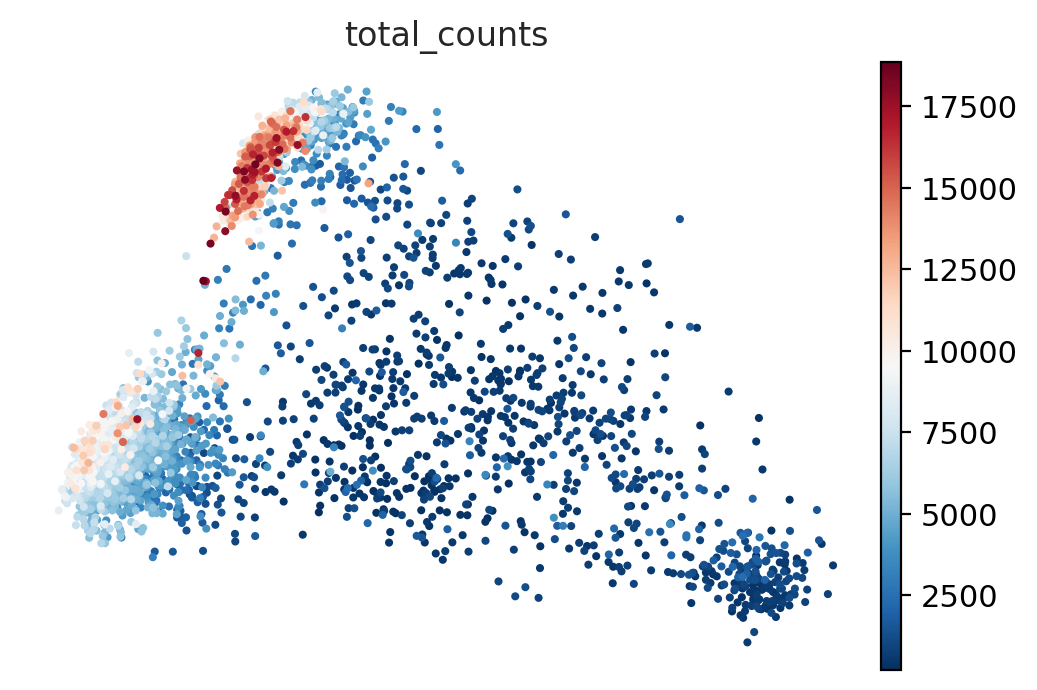

In [ ]:
#@title Plot PCA

sc.pl.pca_scatter(adata_for_PCA, color="total_counts")


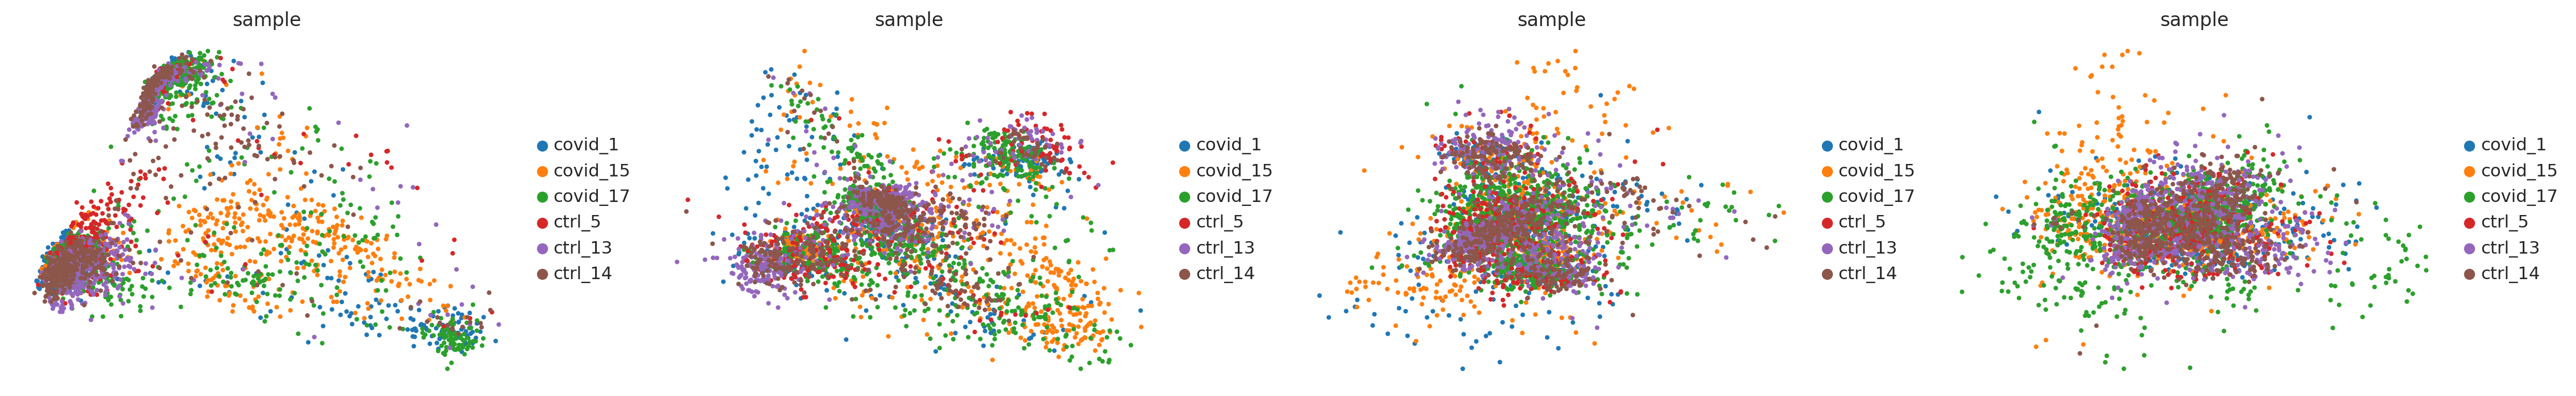

In [ ]:
sc.pl.pca(adata_for_PCA, color='sample', components = ['1,2','3,4','5,6','7,8'], ncols=4)

To identify genes that contribute most to each PC, one can retreive the loading matrix information.

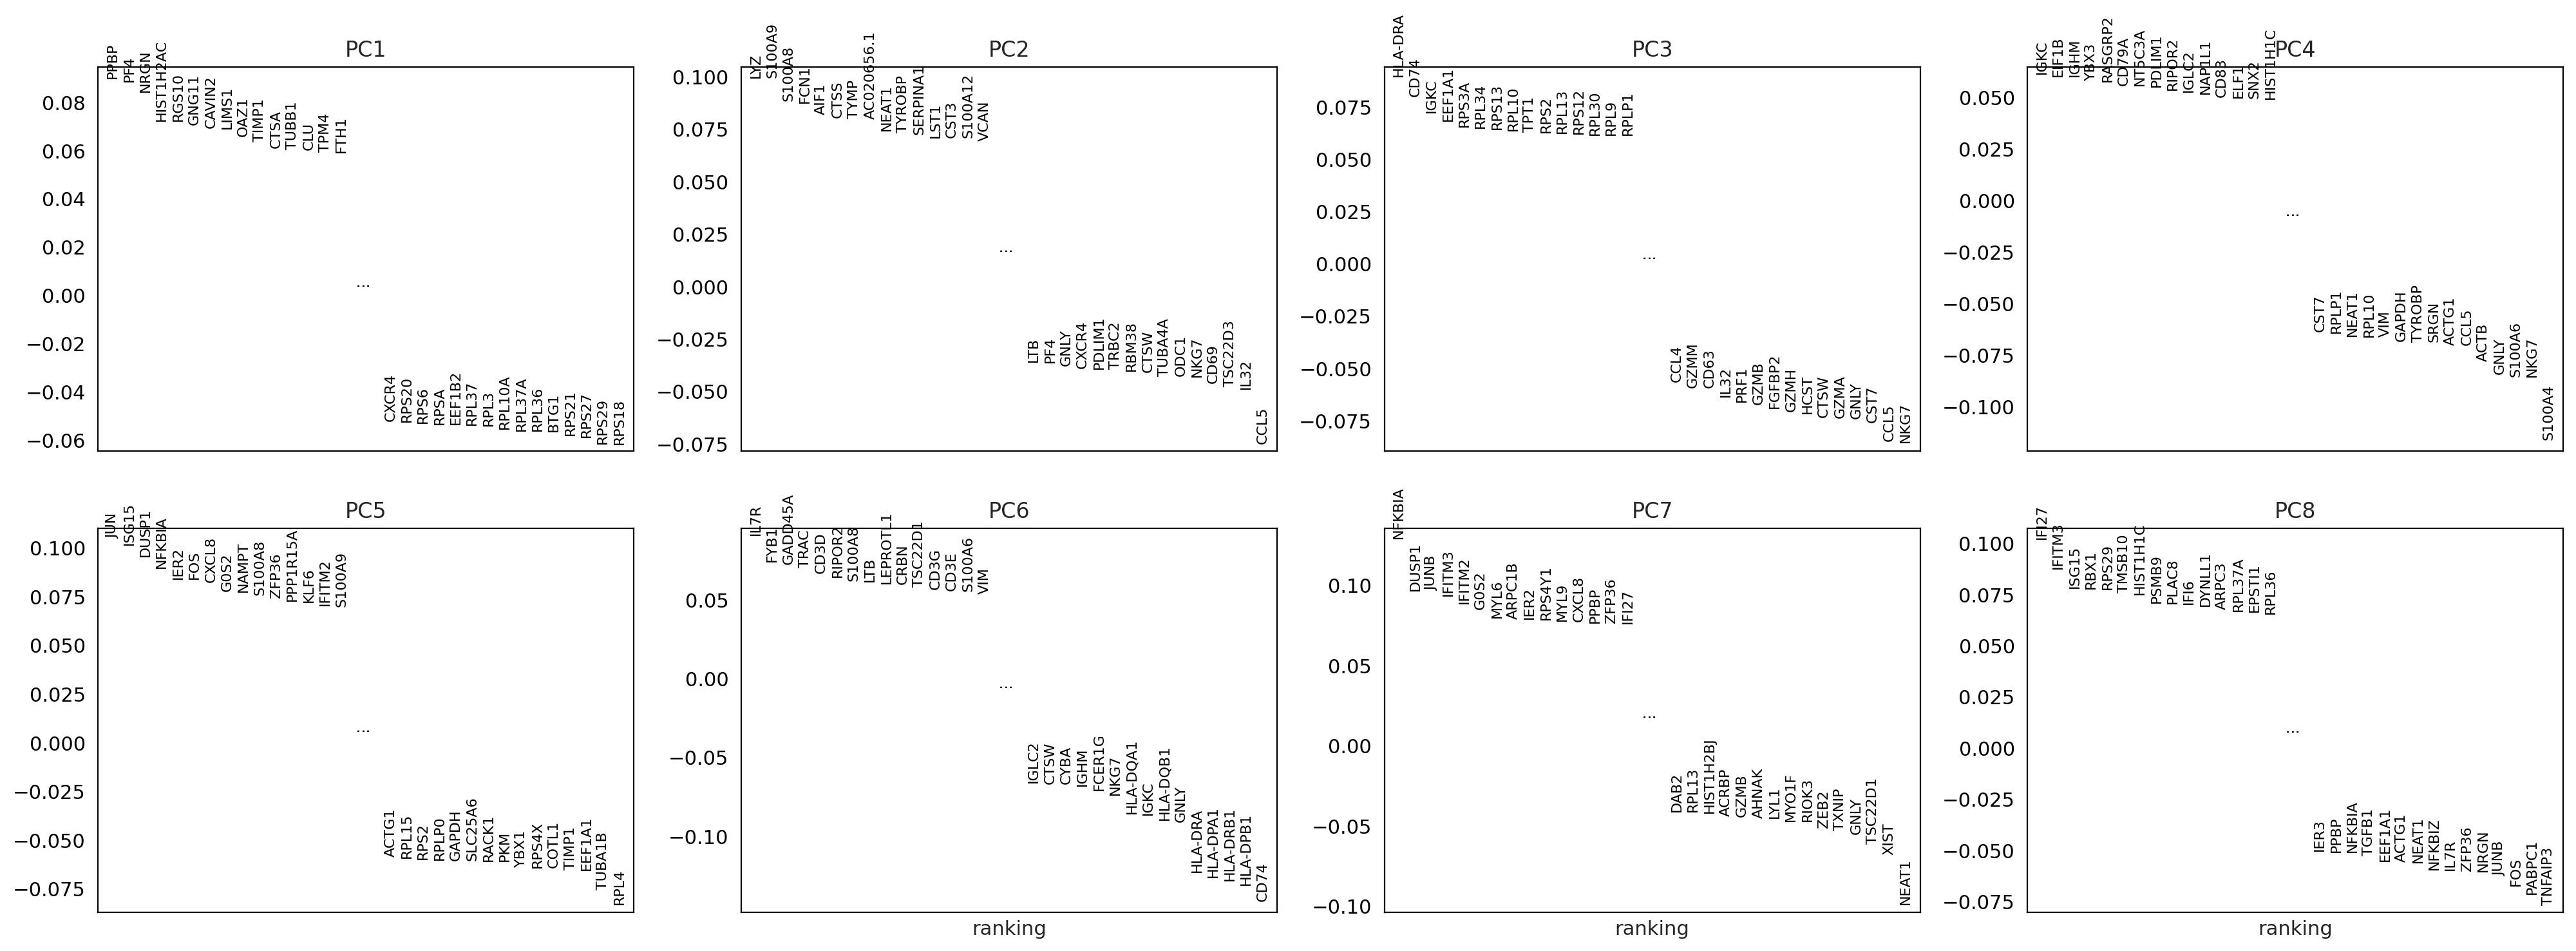

In [ ]:
#Plot loadings
sc.pl.pca_loadings(adata_for_PCA, components=[1,2,3,4,5,6,7,8])

# OBS! only plots the positive axes genes from each PC!!

The function to plot loading genes only plots genes on the positive axes. Instead plot as a heatmaps, with genes on both postive and negative side, one per pc, and plot their expression amongst cells ordered by their position along the pc.

In [ ]:
adata_for_PCA.obs.head(4)

type   sample batch  n_genes_by_counts  total_counts  \
AGGGTCCCATGACCCG-1-0  Covid  covid_1     0               2140        7698.0   
ATTCCTAGTGACTGTT-1-0  Covid  covid_1     0               1808        7535.0   
CCTAAGACAGATTAAG-1-0  Covid  covid_1     0               2449        9025.0   
AATAGAGAGGGTTAGC-1-0  Covid  covid_1     0                392         937.0   

                      pct_counts_in_top_20_genes  total_counts_mt  \
AGGGTCCCATGACCCG-1-0                   24.123149            525.0   
ATTCCTAGTGACTGTT-1-0                   27.458527            470.0   
CCTAAGACAGATTAAG-1-0                   19.789474            513.0   
AATAGAGAGGGTTAGC-1-0                   38.313767             63.0   

                      pct_counts_mt  total_counts_ribo  pct_counts_ribo  ...  \
AGGGTCCCATGACCCG-1-0       6.819953             2564.0        33.307353  ...   
ATTCCTAGTGACTGTT-1-0       6.237558             3397.0        45.082946  ...   
CCTAAGACAGATTAAG-1-0       5.684211             2637.0        29.218837  ...   
AATAGAGAGGGTTAGC-1-0       6.723586               63.0         6.723586  ...   

                      mt_outlier  n_counts   S_score  G2M_score  phase  \
AGGGTCCCATGACCCG-1-0       False    5929.0  0.115495  -0.181939      S   
ATTCCTAGTGACTGTT-1-0       False    5855.0  0.299016   0.346879    G2M   
CCTAAGACAGATTAAG-1-0       False    7611.0  0.407661   0.150615      S   
AATAGAGAGGGTTAGC-1-0       False     773.0  0.071607  -0.092472      S   

                      _scvi_batch  _scvi_labels prediction  leiden  doublet  
AGGGTCCCATGACCCG-1-0            0             0    singlet       2  singlet  
ATTCCTAGTGACTGTT-1-0            0             0    singlet       5  singlet  
CCTAAGACAGATTAAG-1-0            0             0    singlet       5  singlet  
AATAGAGAGGGTTAGC-1-0            0             0    singlet       8  singlet  

[4 rows x 23 columns]

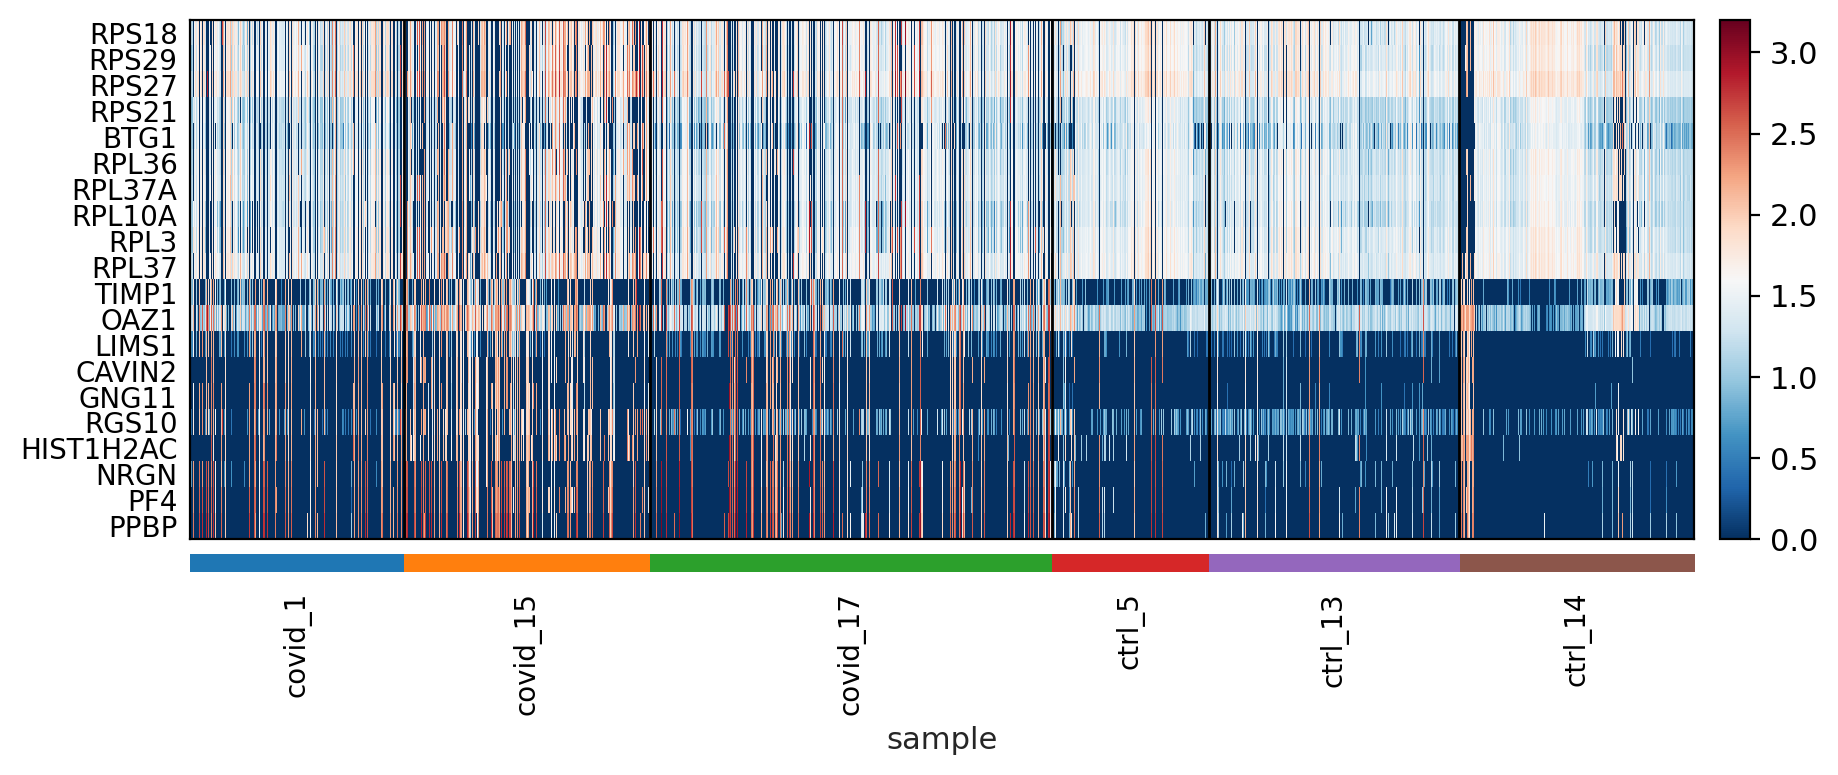

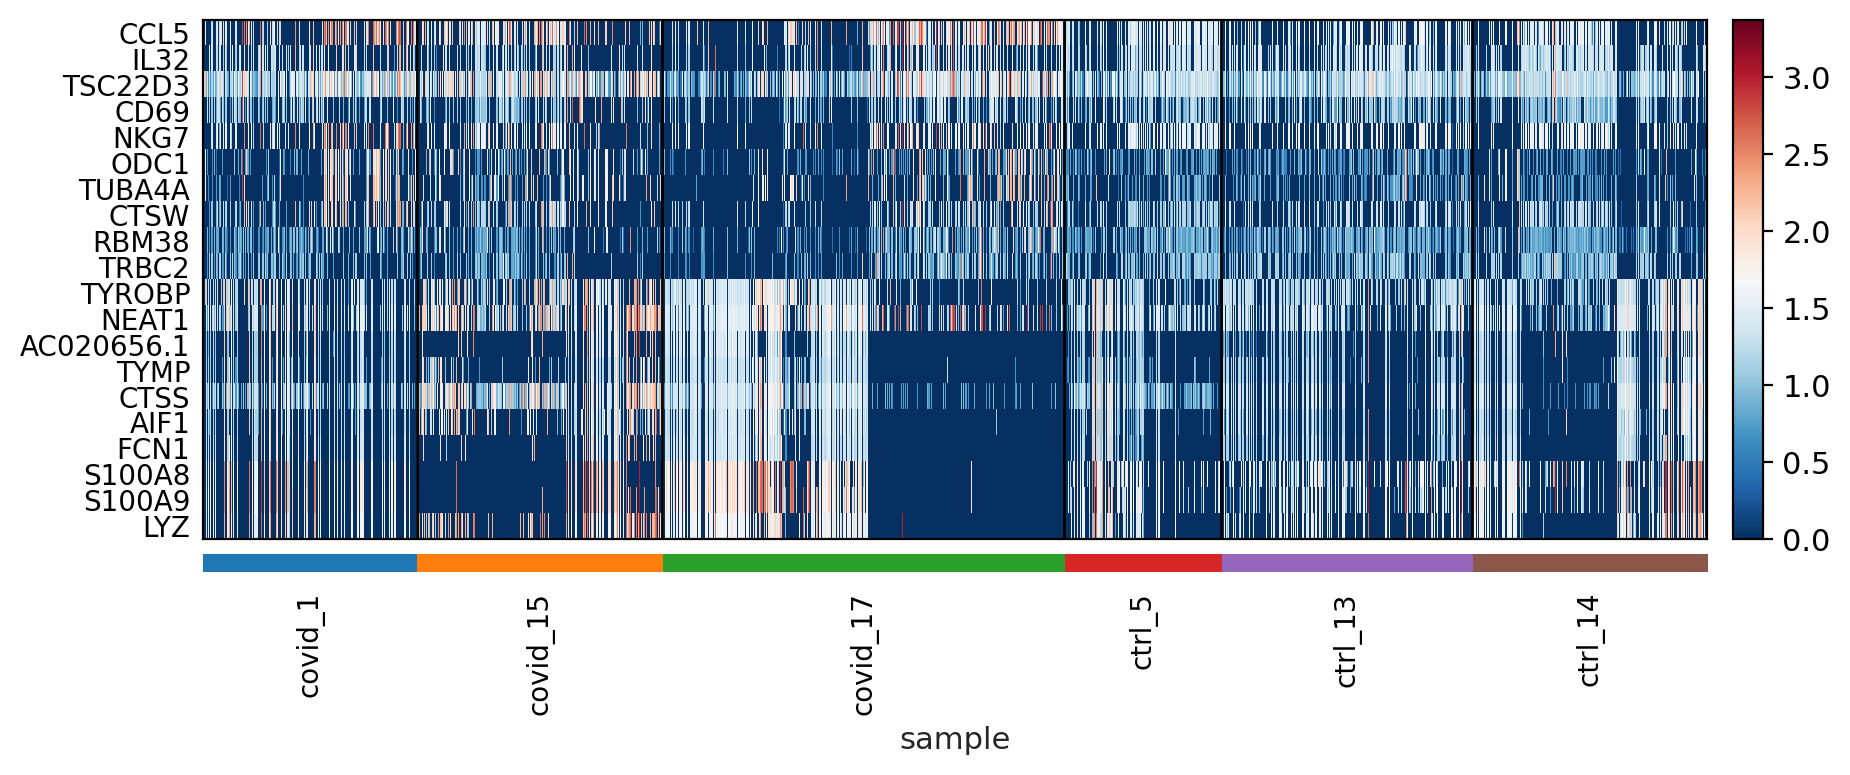

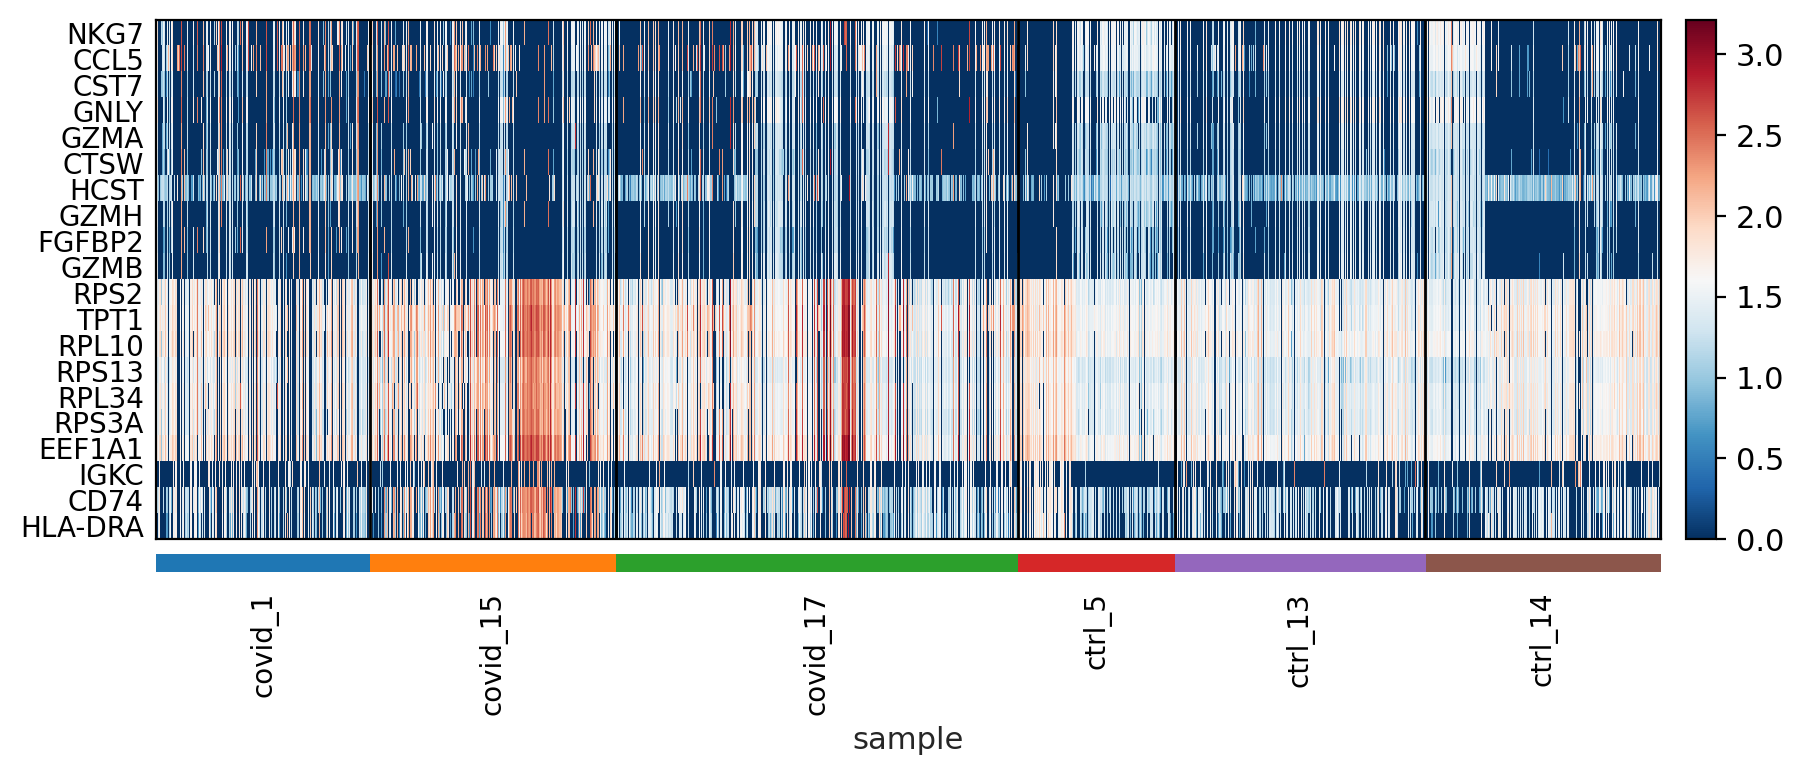

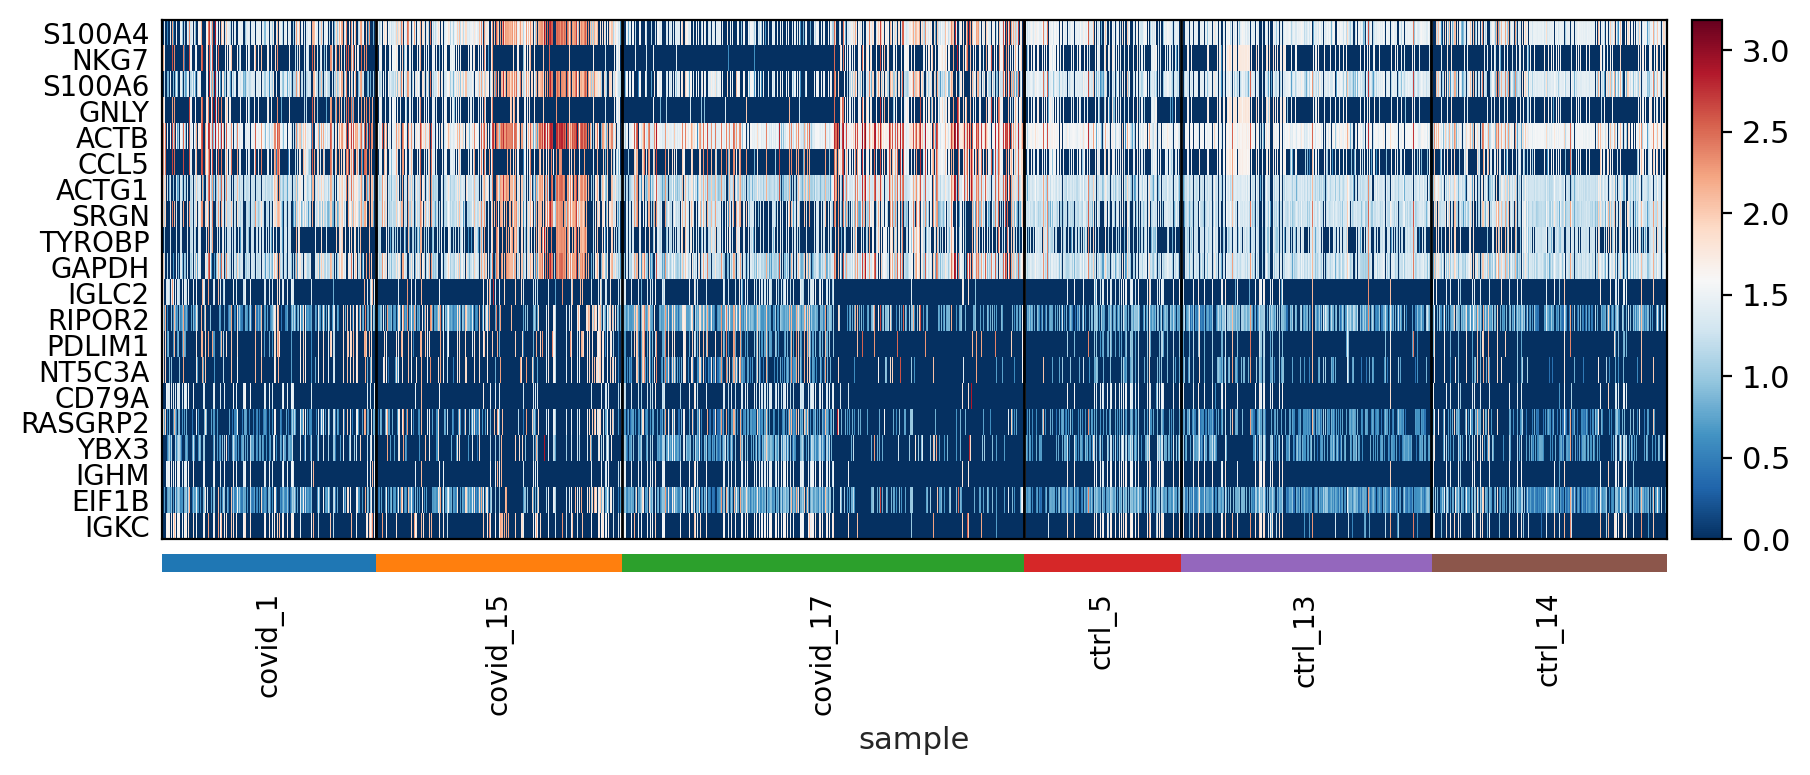

In [ ]:
# adata.obsm["X_pca"] is the embeddings
# adata.uns["pca"] is pc variance
# adata.varm['PCs'] is the loadings

genes = adata_for_PCA.var['gene_ids']

for pc in [1,2,3,4]:
    g = adata_for_PCA.varm['PCs'][:,pc-1]
    o = np.argsort(g)
    sel = np.concatenate((o[:10],o[-10:])).tolist()
    emb = adata_for_PCA.obsm['X_pca'][:,pc-1]
    # order by position on that pc
    tempdata = adata_for_PCA[np.argsort(emb),]
    sc.pl.heatmap(tempdata, var_names = genes[sel].index.tolist(), groupby='sample', swap_axes = True, use_raw=False)




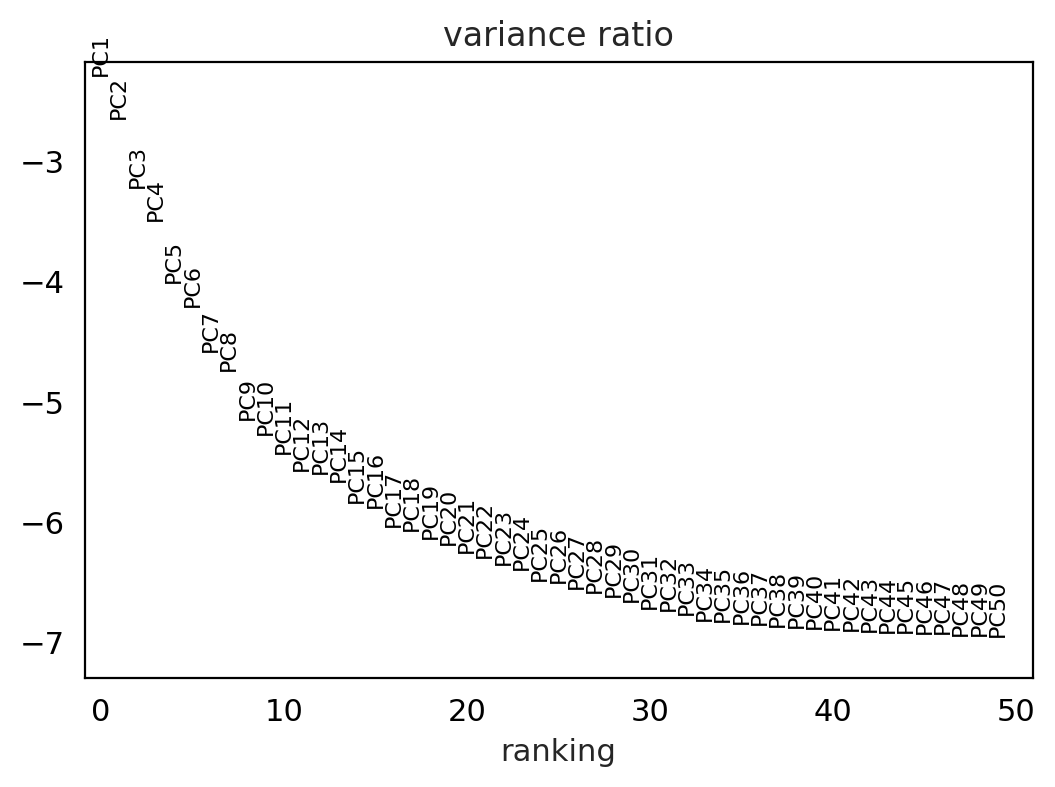

In [ ]:
sc.pl.pca_variance_ratio(adata_for_PCA, log=True, n_pcs = 50)

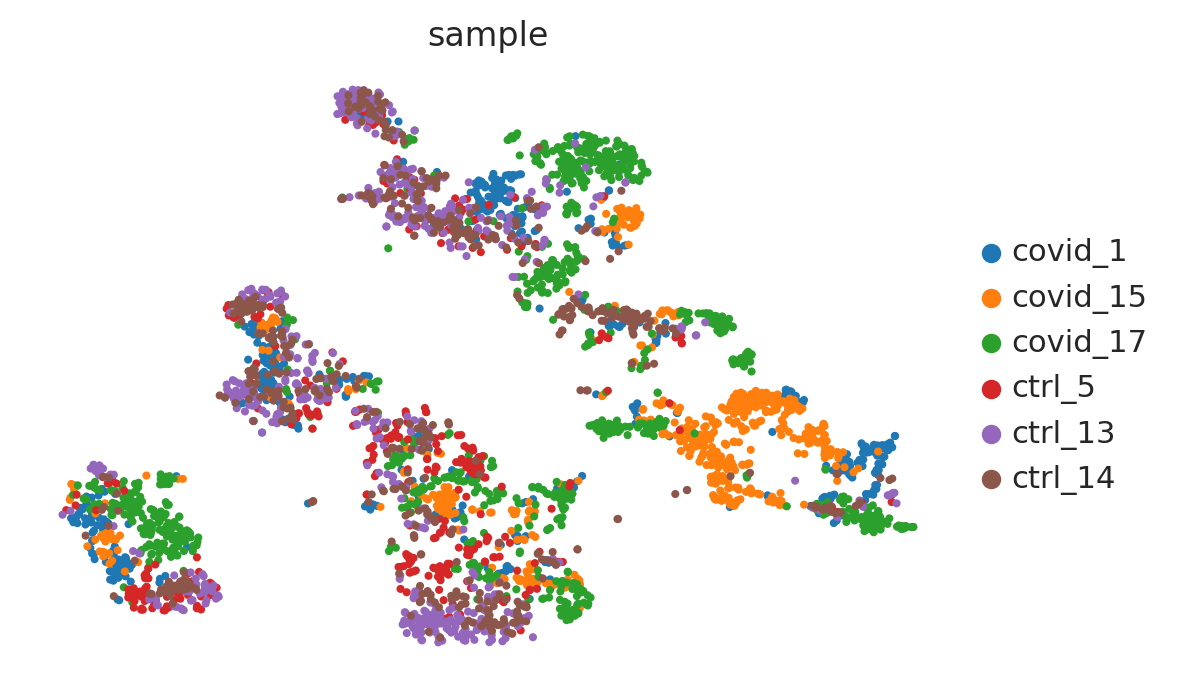

In [ ]:
#@title t-SNE 

sc.tl.tsne(adata_for_PCA, use_rep="X_pca")

sc.pl.tsne(adata_for_PCA, color="sample")



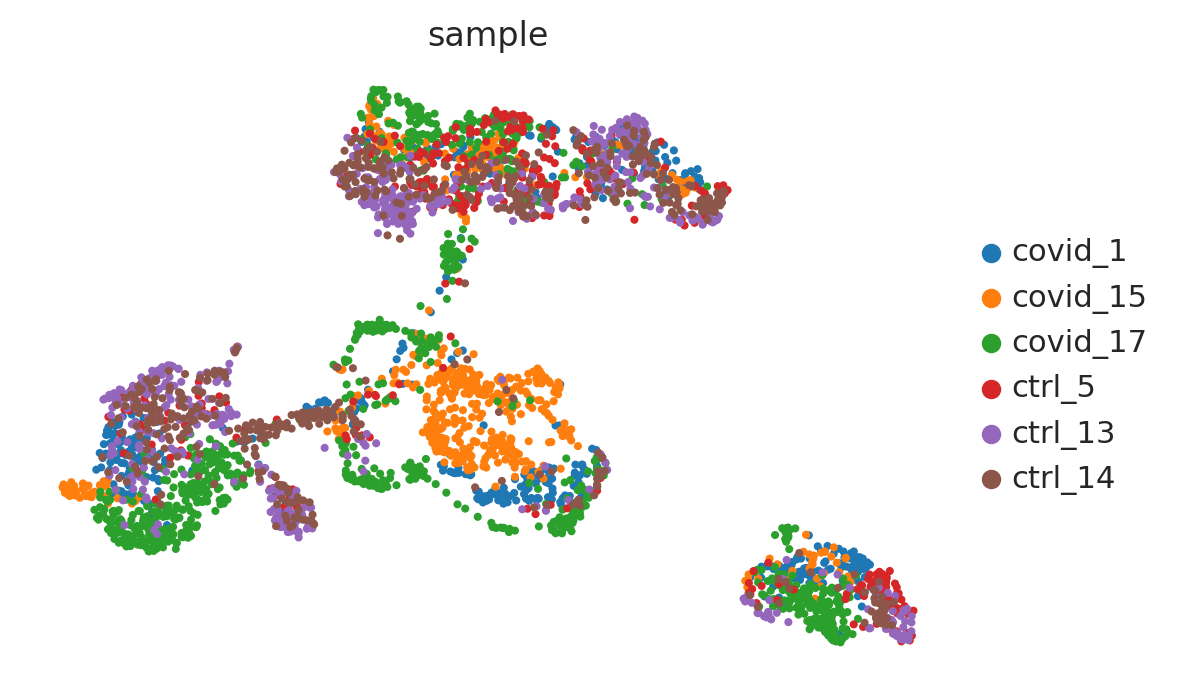

In [ ]:
#@title U-MAP

sc.pp.neighbors(adata_for_PCA)
sc.tl.umap(adata_for_PCA)

sc.pl.umap(adata_for_PCA, color="sample")

In [ ]:
#run with 10 components, save to a new object so that the umap with 2D is not overwritten.
umap10 = sc.tl.umap(adata_for_PCA, n_components=10, copy=True)

<Axes: title={'center': 'UMAP10'}, xlabel='UMAP3', ylabel='UMAP4'>

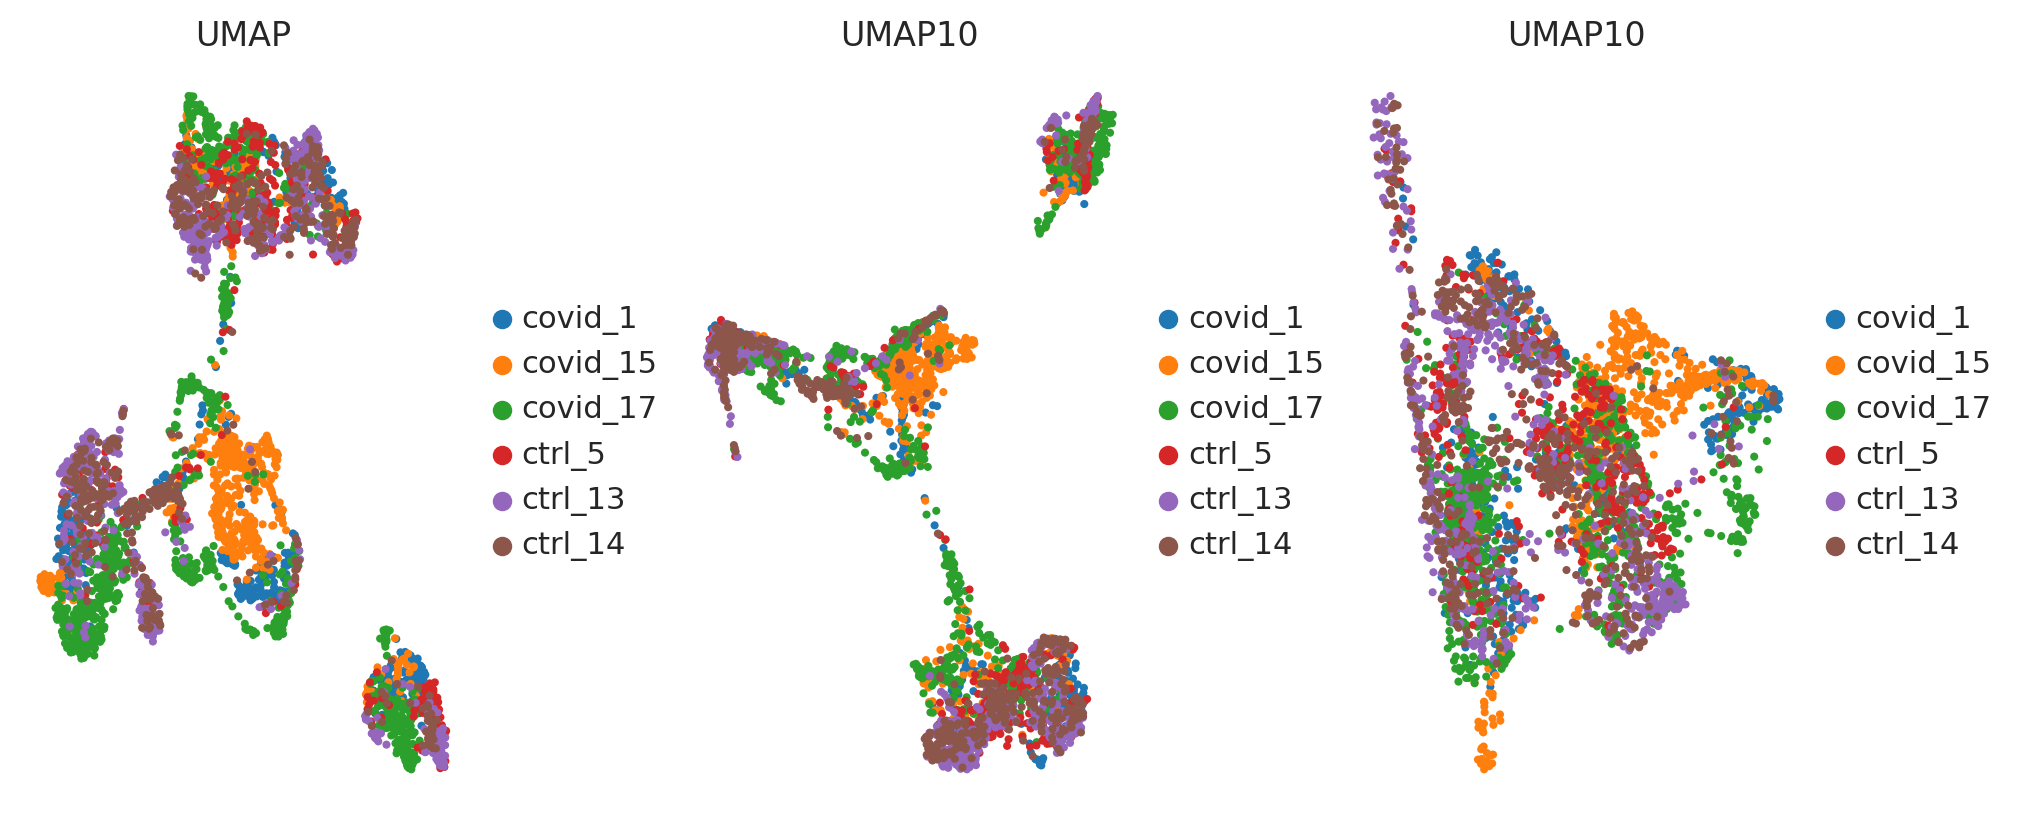

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10,4),constrained_layout=True)

sc.pl.umap(adata_for_PCA, color='sample',  title="UMAP", show=False, ax=axs[0])
sc.pl.umap(umap10, color='sample', title="UMAP10", show=False, ax=axs[1], components=['1,2'])
sc.pl.umap(umap10, color='sample', title="UMAP10", show=False, ax=axs[2], components=['3,4'])

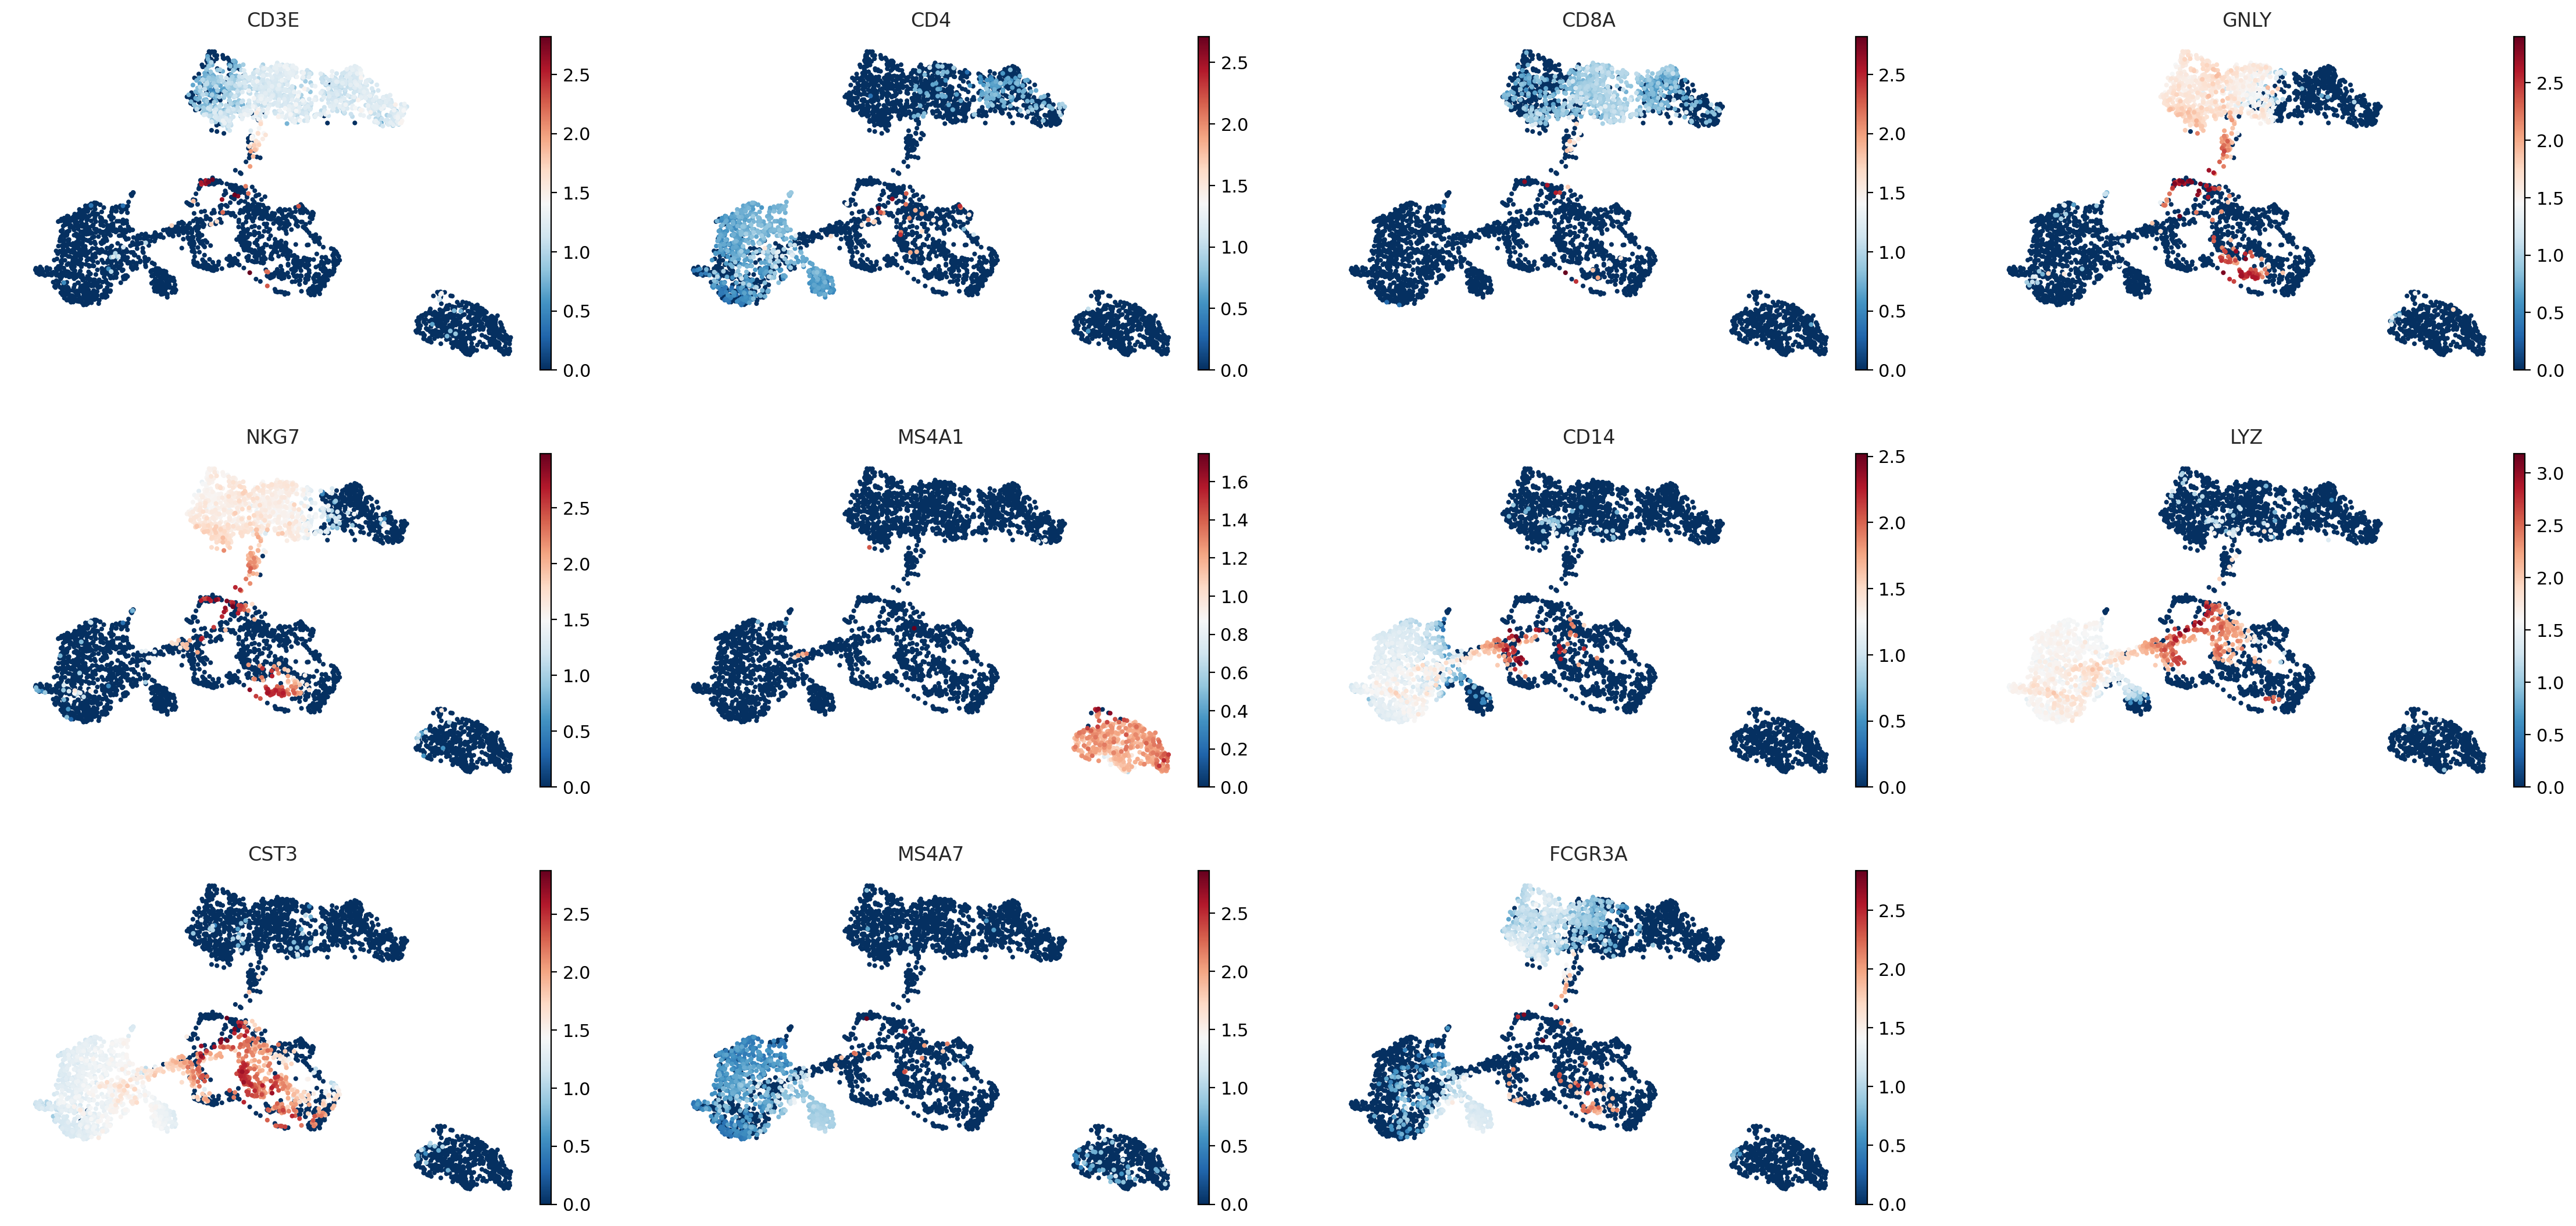

In [ ]:
sc.pl.umap(adata_for_PCA, color=["CD3E", "CD4", "CD8A", "GNLY","NKG7", "MS4A1","CD14","LYZ","CST3","MS4A7","FCGR3A"])

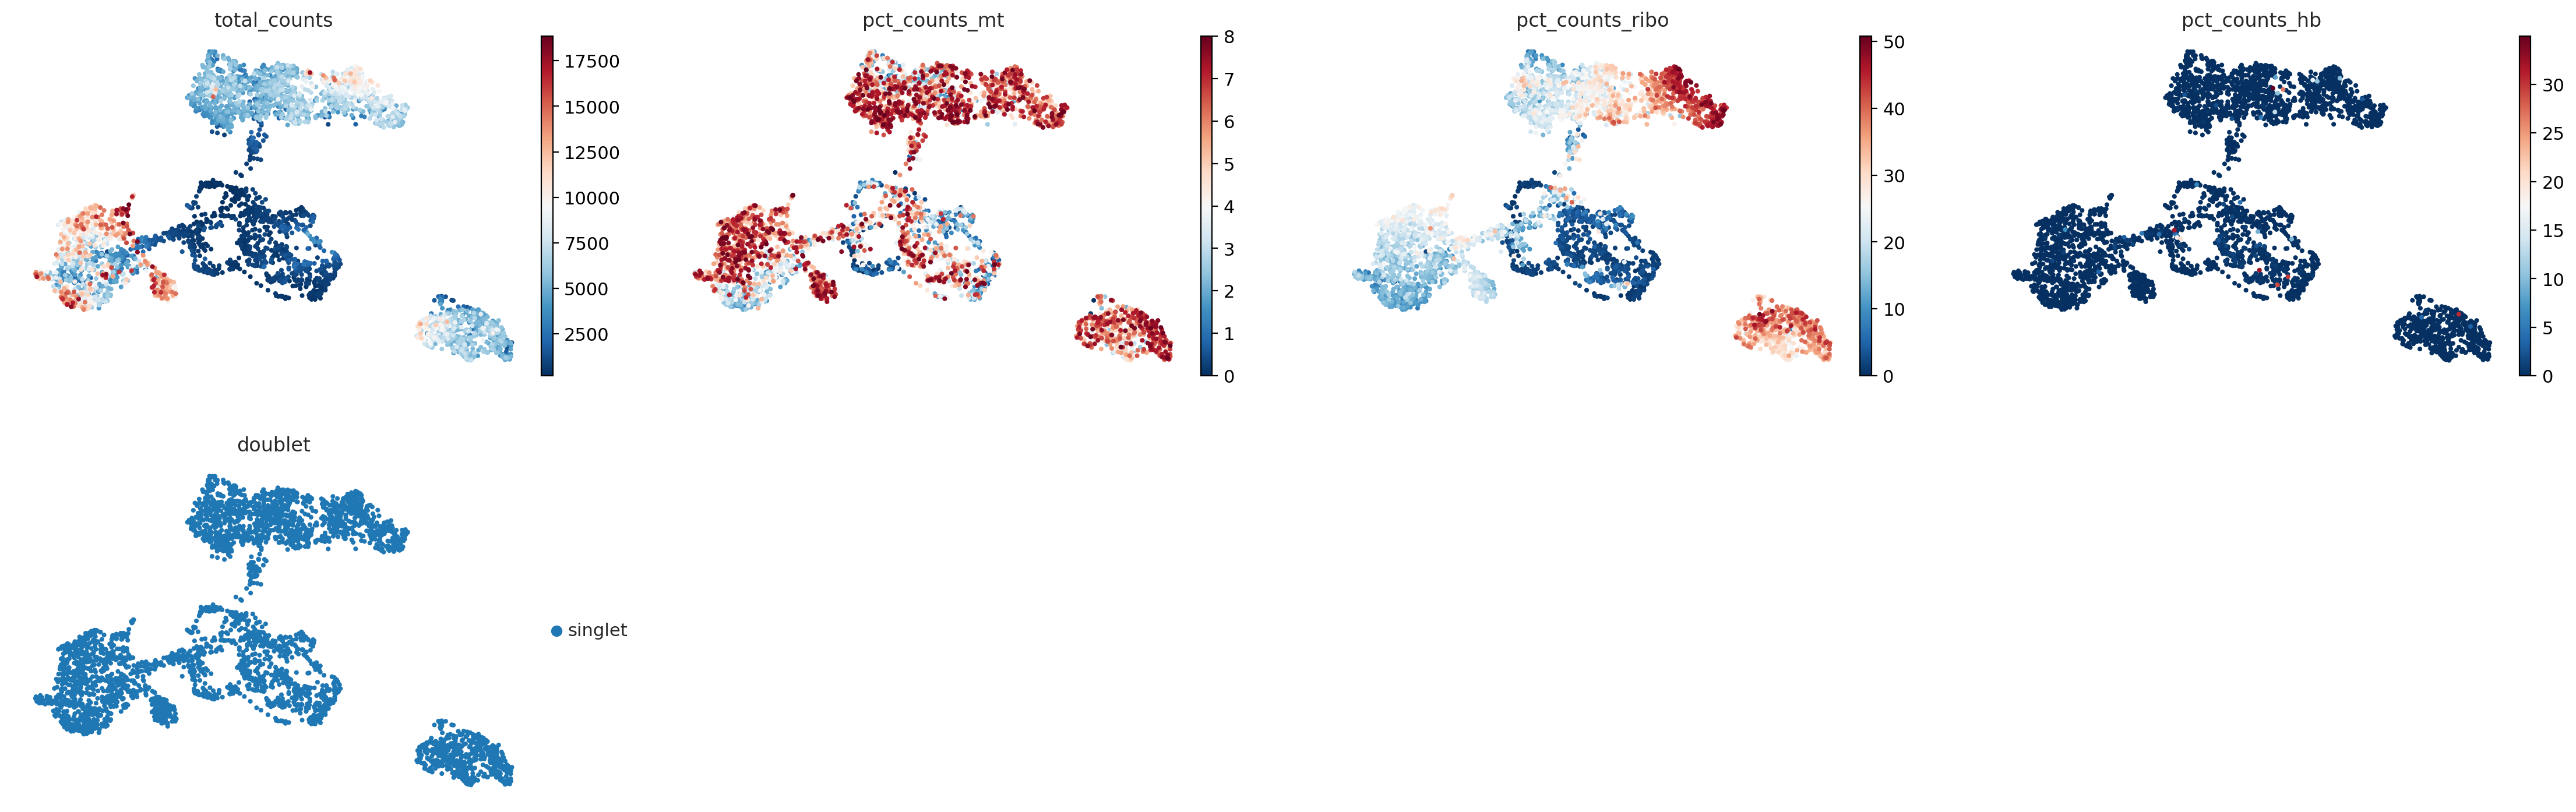

In [ ]:
sc.pl.umap(
    adata_for_PCA,
    color=["total_counts", "pct_counts_mt", 'pct_counts_ribo', 'pct_counts_hb', "doublet"],
)


### Save QC filtered feature selected , DM reduced data object

In [ ]:

save_file = 'Objects/sc_QCNFSDM_covid.h5ad'
adata_for_PCA.write_h5ad(save_file)
